# Project Description: Customer Segmentation for Promotional Strategies to Prevent Churn

#### Objective:
The primary objective of this project is to segment our customer base using clustering techniques to identify distinct groups of customers. By understanding the characteristics of these segments, we aim to develop targeted promotional strategies that will help prevent customer churn.

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [148]:
df = pd.read_csv('/kaggle/input/churn-modelling/Churn_Modelling.csv')

### Data Preprocessing

In [149]:
# Simplifying column names and bringing consistency
df.columns = [name.lower() for name in list(df.columns)]
df.drop(['rownumber','customerid','surname'],axis=1,inplace=True)
df.rename(columns={"exited": "churn"}, inplace=True)


In [150]:
# Select only the churn customer
df_churn = df[df['churn']==1]

In [151]:
df_churn.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
16,653,Germany,Male,58,1,132602.88,1,1,0,5097.67,1


#### Transforming

In [152]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from yellowbrick.cluster import SilhouetteVisualizer

In [153]:
# Define the columns
numerical = ['creditscore', 'age', 'tenure','balance', 'estimatedsalary', 'numofproducts', 'hascrcard', 'isactivemember']
categorical = ['geography', 'gender']

# Define the column transformer to encode the categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical)
    ], remainder='passthrough')  # Passthrough numerical columns for now

# Define a pipeline to first apply the preprocessor and then scale all features
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler())  
])

# Fit the pipeline on the data and transform it
X = df_churn.drop('churn', axis=1)
y = df_churn['churn']
X_transformed = pipeline.fit_transform(X)

# Extract feature names after encoding
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical)
all_feature_names = list(encoded_feature_names) + numerical

# Convert the transformed data back to a DataFrame
df_preprocessed = pd.DataFrame(X_transformed, columns=all_feature_names)

## K Means

In [154]:
df_preprocessed.head()

,geography_Germany,geography_Spain,gender_Male,creditscore,age,tenure,balance,estimatedsalary,numofproducts,hascrcard,isactivemember
0,-0.815829,-0.504292,-0.887925,-0.262735,-0.290803,-0.999100,-1.561509,-0.593029,0.656108,1.330950,-0.002017
1,-0.815829,-0.504292,-0.887925,-1.429272,-0.290803,1.044924,1.174917,1.902841,0.656108,-0.751343,0.215307
2,-0.815829,1.982978,1.126221,-0.003505,-0.085868,1.044924,0.388151,0.654906,0.656108,-0.751343,0.834068
3,1.225748,-0.504292,-0.887925,-2.685542,-1.622884,-0.317759,0.410277,3.150776,0.656108,-0.751343,0.308839
4,1.225748,-0.504292,1.126221,0.076259,1.348681,-1.339771,0.711171,-0.593029,0.656108,-0.751343,-1.664439


In [155]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

In [156]:
sse = []  # Sum of Squared Errors
cluster_range = range(1, 11)  # Adjust the range if needed

for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(df_preprocessed)
    sse.append(kmeans.inertia_)  # kmeans.inertia_ gives the SSE/WCSS

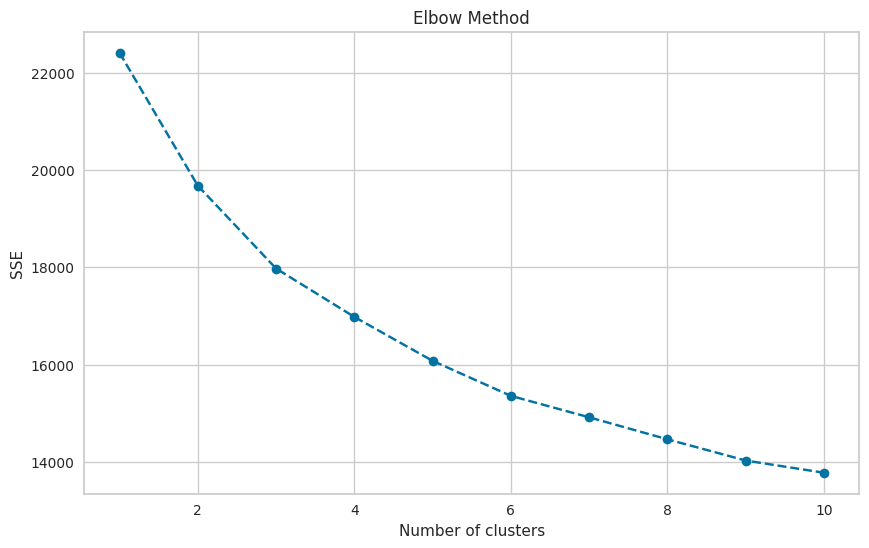

In [157]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, sse, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.grid(True)
plt.show()


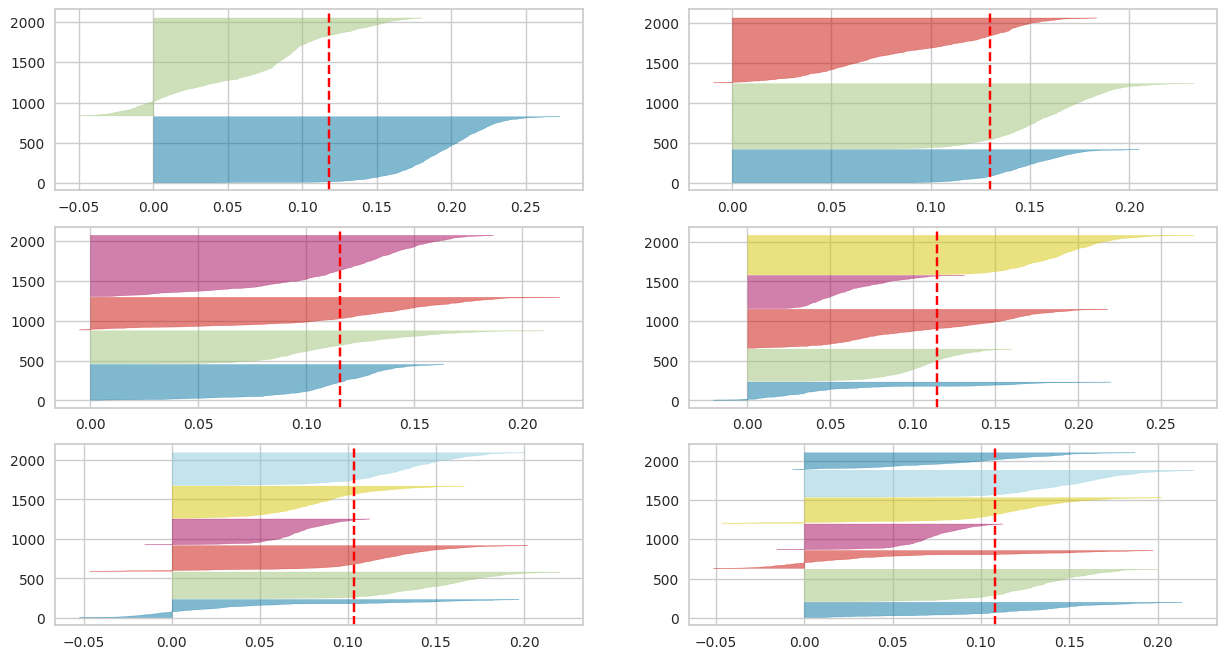

In [158]:
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5,6,7]:
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_preprocessed) 

Choosing the optimal number of clusters using the elbow method can be challenging when the plot does not clearly flatten out. In such cases, using silhouette analysis to determine the number of clusters may be more effective, and based on this analysis, selecting three clusters would be appropriate.

In [159]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42,n_init=10)
kmeans_model = kmeans.fit(df_preprocessed)

cluster_labels = kmeans_model.predict(df_preprocessed)

In [160]:
df_churn_original = df[df['churn']==1]
df_churn_original['cluster'] = cluster_labels

/tmp/ipykernel_33/1914590516.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_churn_original['cluster'] = cluster_labels


In [161]:
df_churn_original['cluster'].value_counts()

cluster
1    814
2    810
0    413
Name: count, dtype: int64

In [162]:
import seaborn as sns

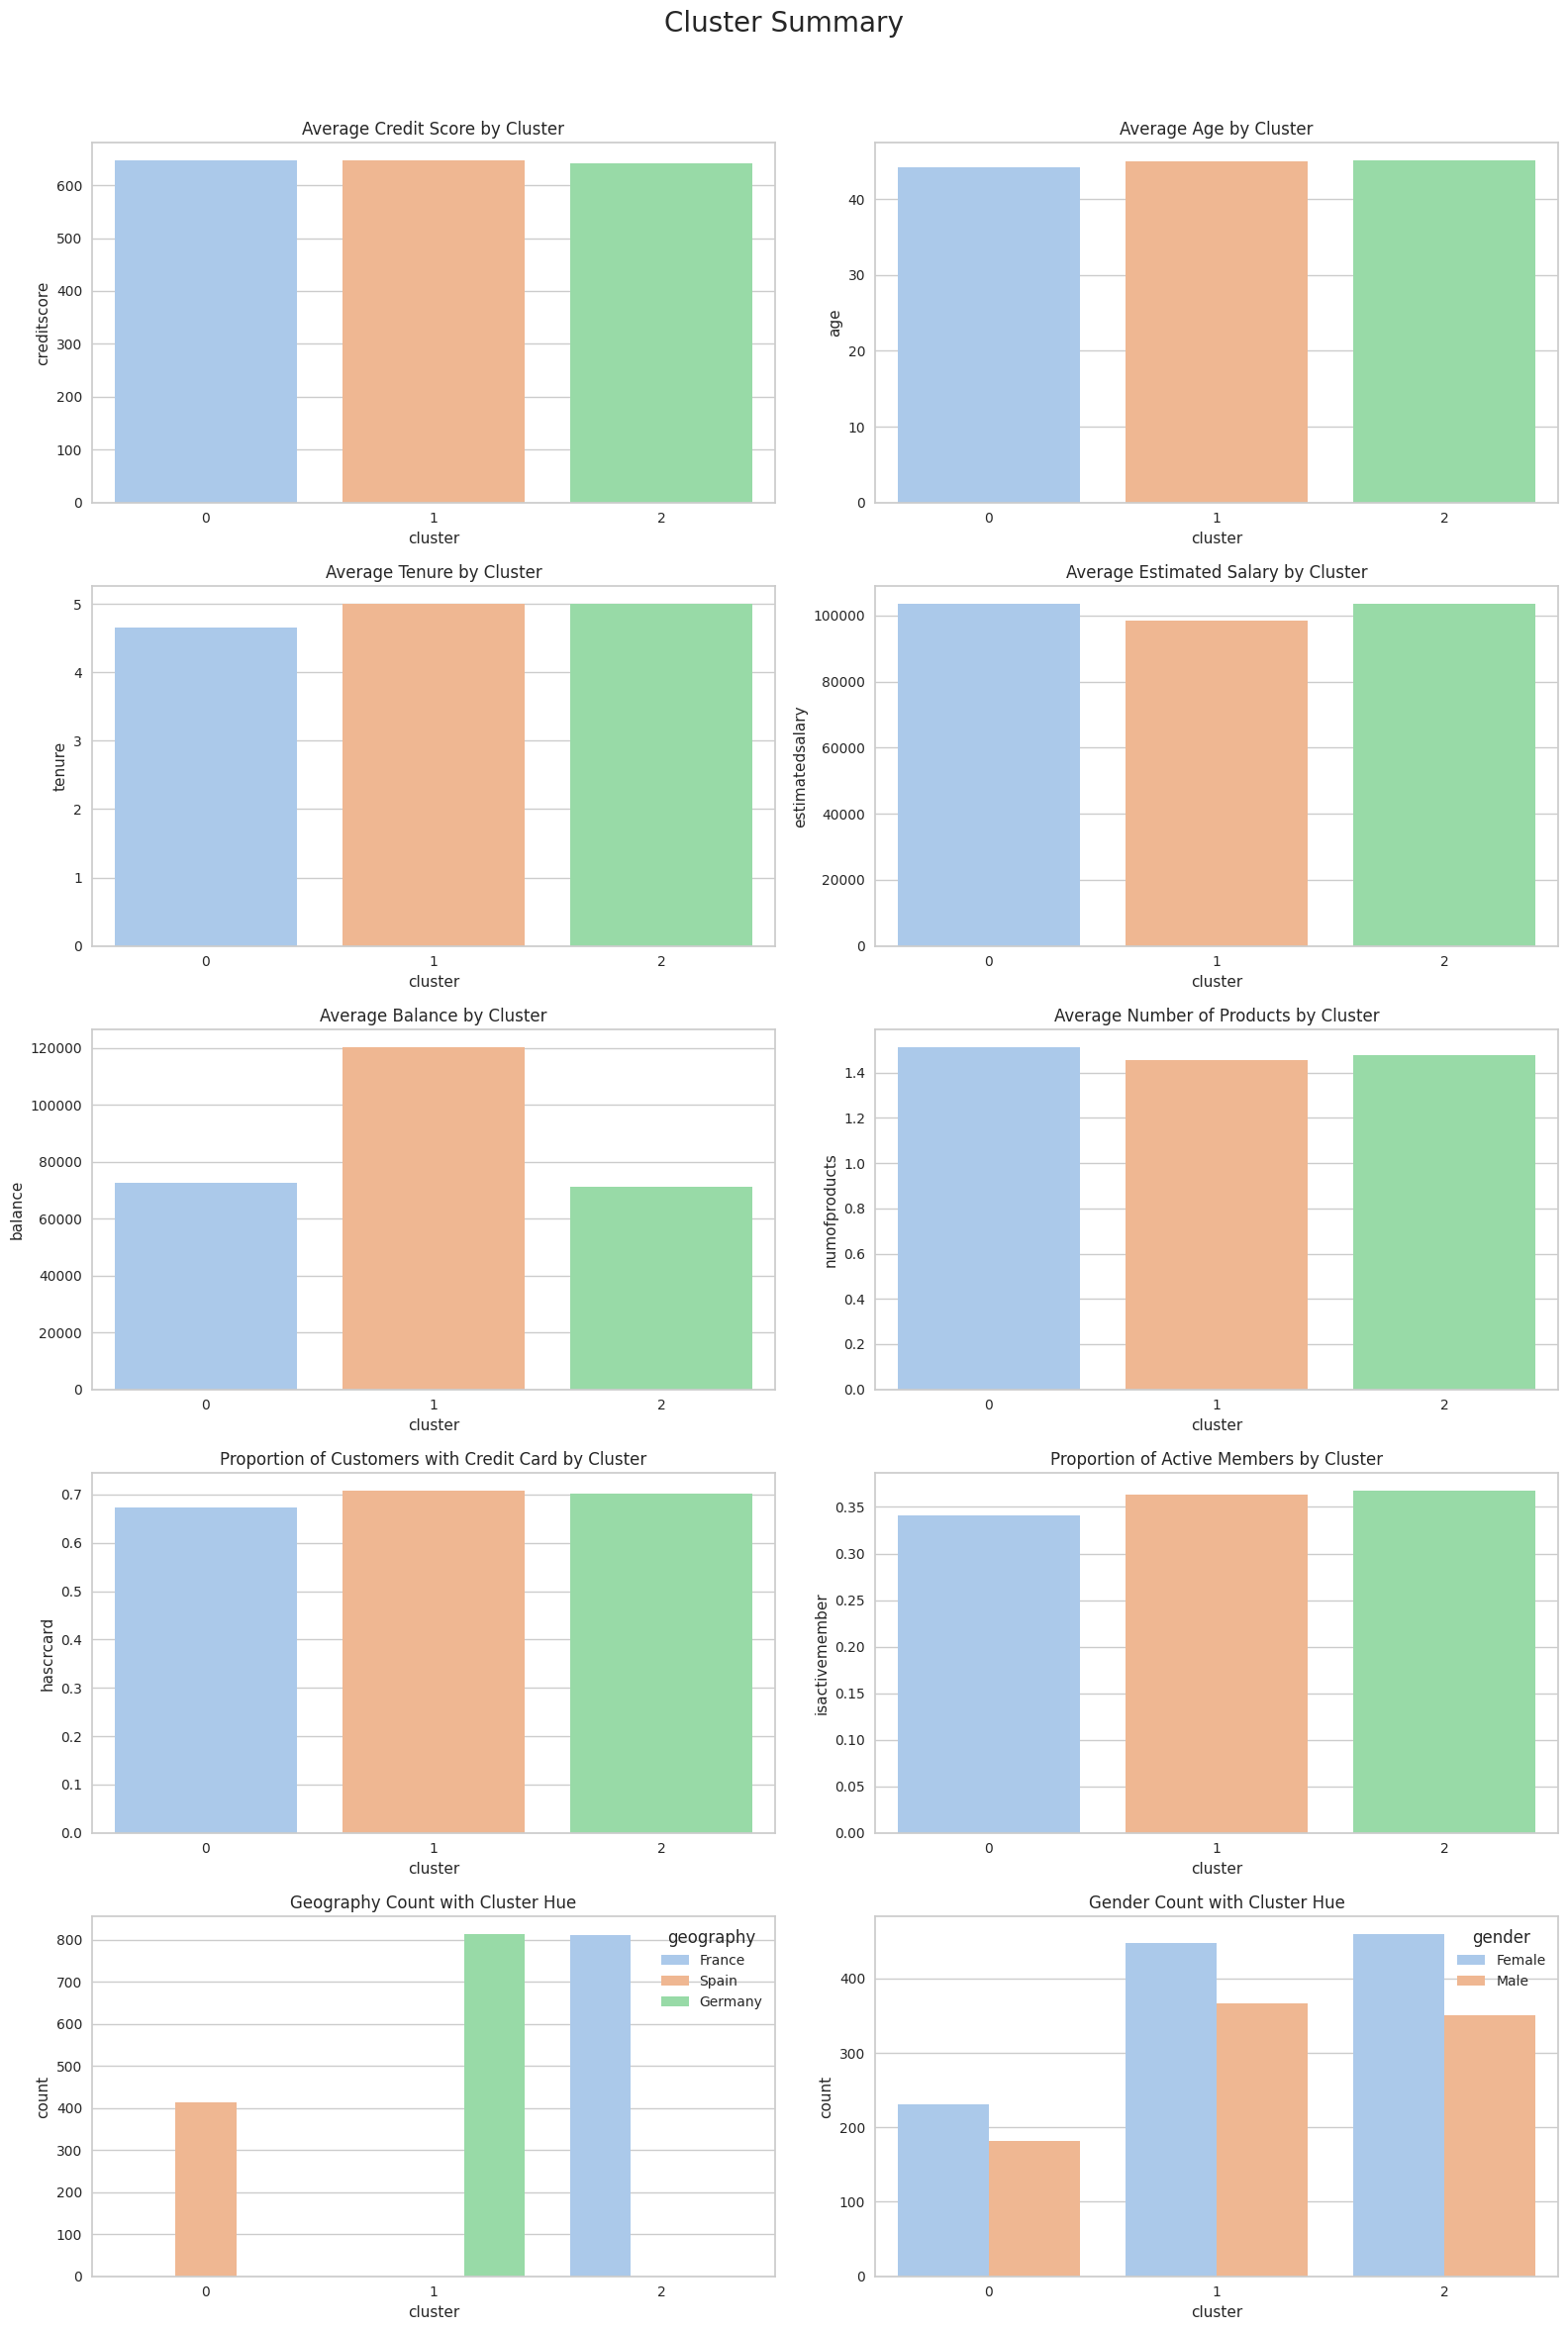

In [163]:
# Create a summary of the clusters
cluster_summary = df_churn_original.groupby('cluster').agg({
    'creditscore': 'mean',
    'age': 'mean',
    'tenure': 'mean',
    'balance': 'mean',
    'estimatedsalary': 'mean',
    'numofproducts': 'mean',
    'hascrcard': 'mean',
    'isactivemember': 'mean'
}).reset_index()

# Set up the figure with subplots
fig, axs = plt.subplots(5, 2, figsize=(16, 24))
fig.suptitle('Cluster Summary', fontsize=20)

# Creditscore by Cluster
sns.barplot(x='cluster', y='creditscore', data=cluster_summary, ax=axs[0, 0], palette='pastel')
axs[0, 0].set_title('Average Credit Score by Cluster')

# Age by Cluster
sns.barplot(x='cluster', y='age', data=cluster_summary, ax=axs[0, 1], palette='pastel')
axs[0, 1].set_title('Average Age by Cluster')

# Tenure by Cluster
sns.barplot(x='cluster', y='tenure', data=cluster_summary, ax=axs[1, 0], palette='pastel')
axs[1, 0].set_title('Average Tenure by Cluster')

# Estimated Salary by Cluster
sns.barplot(x='cluster', y='estimatedsalary', data=cluster_summary, ax=axs[1, 1], palette='pastel')
axs[1, 1].set_title('Average Estimated Salary by Cluster')

# Balance by Cluster
sns.barplot(x='cluster', y='balance', data=cluster_summary, ax=axs[2, 0], palette='pastel')
axs[2, 0].set_title('Average Balance by Cluster')

# Number of Products by Cluster
sns.barplot(x='cluster', y='numofproducts', data=cluster_summary, ax=axs[2, 1], palette='pastel')
axs[2, 1].set_title('Average Number of Products by Cluster')

# Has Credit Card by Cluster
sns.barplot(x='cluster', y='hascrcard', data=cluster_summary, ax=axs[3, 0], palette='pastel')
axs[3, 0].set_title('Proportion of Customers with Credit Card by Cluster')

# Is Active Member by Cluster
sns.barplot(x='cluster', y='isactivemember', data=cluster_summary, ax=axs[3, 1], palette='pastel')
axs[3, 1].set_title('Proportion of Active Members by Cluster')

# Geography Count with Cluster Hue
sns.countplot(data=df_churn_original, x='cluster', hue='geography', ax=axs[4, 0], palette='pastel')
axs[4, 0].set_title('Geography Count with Cluster Hue')

# Gender Count with Cluster Hue
sns.countplot(data=df_churn_original, x='cluster', hue='gender', ax=axs[4, 1], palette='pastel')
axs[4, 1].set_title('Gender Count with Cluster Hue')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Based on the clustering summary, we can tailor our promotional strategies to target each customer segment effectively. Here are the suggested promotional strategies for each cluster:

#### Cluster 0: Spain - Low Balance
**Characteristics:**
- Customers from Spain
- Low account balance

**Promotional Strategy:**
- **Offer Low-Interest Loans:** Encourage financial engagement by providing low-interest personal loans or credit cards.
- **Savings Incentives:** Introduce incentives for increasing account balances, such as matching contributions or bonus interest rates for deposits.

#### Cluster 1: France - High Balance
**Characteristics:**
- Customers from France
- High account balance

**Promotional Strategy:**
- **Exclusive Investment Opportunities:** Offer exclusive access to high-yield investment products and financial planning services.
- **Loyalty Rewards:** Implement a loyalty rewards program that provides perks such as travel vouchers, concierge services, or premium credit card benefits.
- **Referral Bonuses:** Provide bonuses for referring friends or family to the bank.

#### Cluster 2: Germany - Low Balance
**Characteristics:**
- Customers from Germany
- Low account balance

**Promotional Strategy:**
- **Fee Waivers:** Offer fee waivers for maintaining low balances, such as waiving monthly maintenance fees.
- **Budgeting Tools:** Provide access to budgeting and financial management tools to help customers manage their finances better.
- **Cashback Programs:** Introduce cashback programs for everyday purchases to incentivize the use of bank products.

By implementing these targeted promotional strategies, we can effectively address the needs and preferences of each customer segment, thereby reducing the risk of churn and enhancing customer loyalty.